In [30]:
from scipy.integrate import odeint
import time
import math
import numpy as np
import pylab as py
from math import *
import numpy as np
from scipy.optimize import newton
from matplotlib import animation, rc
from matplotlib import pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from IPython.display import HTML
import import_ipynb
import diffusion_functions_meta_training
import warnings
import os

In [31]:
print(torch.cuda.is_available())  # Sollte True zurückgeben, wenn CUDA korrekt funktioniert.
print(torch.__version__)  # Zeigt die PyTorch-Version.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

False
2.5.1+cpu
cpu


In [32]:
# Ignoriere alle UserWarnings
warnings.filterwarnings("ignore", category=UserWarning)

# Ignoriere Warnungen, die "X does not have valid feature names" enthalten
warnings.filterwarnings("ignore", message="X does not have valid feature names")

# Ignoriere Warnungen aus dem sklearn-Modul
warnings.filterwarnings("ignore", module="sklearn")

In [33]:
# Parameters
length = 1  # Length of the domain
Total_simulation_time = 7.5  # Total time
nx = 60  # Number of spatial points
nt = 3755 # Number of time steps
alpha = 0.02  # Diffusion coefficient

dx = length / (nx - 1)
dt = Total_simulation_time / nt

# Avoid that results converge to inifinity
if alpha * dt / dx**2 > 0.5:
    raise ValueError("Stability condition violated")

time = np.linspace(0, Total_simulation_time, nt)

In [34]:
# Initial condition: Gaussian distribution
x = np.linspace(0, length, nx)
# T_initial1 = np.exp(-((x - length/2)**2) / (2 * (length/10)**2))+80
T_initial1 = 10 * np.sin(2 * np.pi * x / length) + 20

# T_initial3 = np.exp(-((x - length/4)**2) / (2 * (length/20)**2)) + \
#              np.exp(-((x - 3*length/4)**2) / (2 * (length/20)**2)) + 20


initial_condition_list = [T_initial1]

simulation_sets = diffusion_functions_meta_training.multi_simulations(initial_condition_list, nt, nx, dt, dx, alpha)

In [35]:
scaler = MinMaxScaler(feature_range=(-1, 1))
train_datasets, test_datasets = diffusion_functions_meta_training.data_splitter_and_scaler(scaler, simulation_sets, nx, test_size = 0.2)

3004


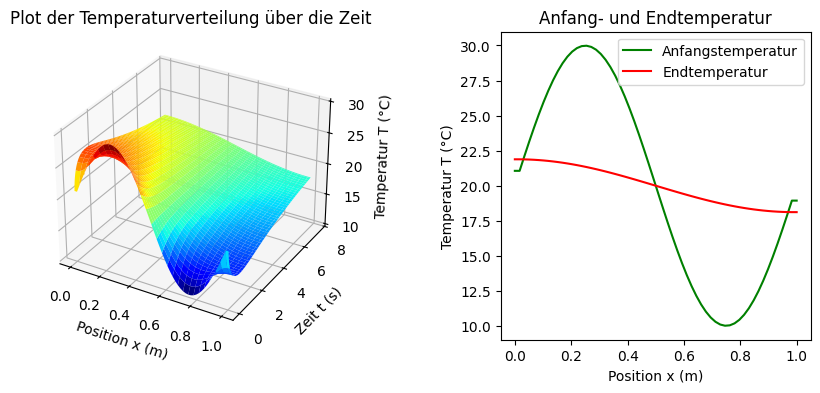

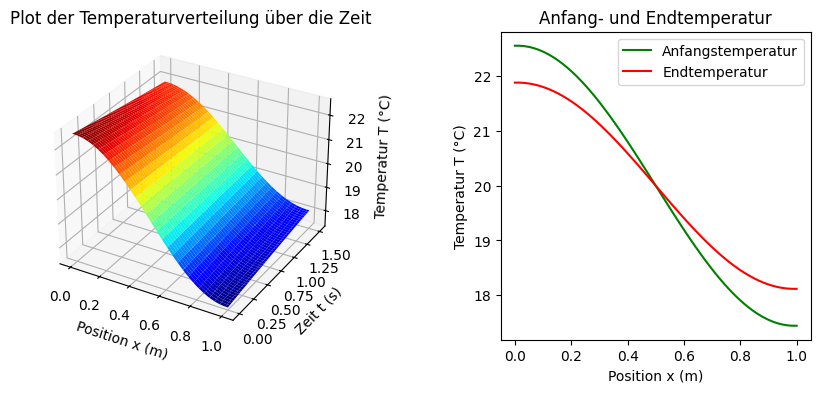

In [ ]:
diffusion_functions_meta_training.plot_the_temp_evolution(simulation_sets[0], x, Total_simulation_time, test_size = 1)
diffusion_functions_meta_training.plot_the_temp_evolution(test_datasets[0], x, Total_simulation_time, test_size = 0.2)

In [37]:
#1. Accesses the simulation with the params
#2. chooses the Batches
#3. Acesses the batches and you can choose between 1 (targed_batch / Labeled_batch) and 0 (training_batch)
print(train_datasets[0][0][1])

tensor([[-0.6437, -0.6437, -0.8396, -0.6501, -0.1751,  0.3006,  0.7376,  0.9515,
          0.9545,  0.9565,  0.9580,  0.9591,  0.9600,  0.9607,  0.9613,  0.9618,
          0.9622,  0.9625,  0.9628,  0.9630,  0.9632,  0.9634,  0.9636,  0.9637,
          0.9638,  0.9639,  0.9639,  0.9640,  0.9640,  0.9640, -0.9640, -0.9640,
         -0.9640, -0.9639, -0.9639, -0.9638, -0.9637, -0.9636, -0.9634, -0.9632,
         -0.9630, -0.9628, -0.9625, -0.9622, -0.9618, -0.9613, -0.9607, -0.9600,
         -0.9591, -0.9580, -0.9565, -0.9545, -0.9515, -0.7376, -0.3006,  0.1751,
          0.6501,  0.8396,  0.6437,  0.6437]])


We will take to solutions.  the first is from the stable region and the second is chaotic

In [38]:
class MyLSTM(nn.Module):
    def __init__(self, input_size=4, hidden_size=100, num_layers=1):

        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers)
        self.linear = nn.Linear(hidden_size, input_size)
        self.c_h = (
            torch.zeros(num_layers, 1, hidden_size),
            torch.zeros(num_layers, 1, hidden_size)
        )

    def forward(self, x):
        h, self.c_h = self.lstm(x.view(len(x), 1, -1), self.c_h)
        predictions = self.linear(h.view(len(x), -1))
        return predictions[-1]

    def freeze_layers(self, model, num_layers_to_freeze):
        layer_idx = 0
        for name, param in model.named_parameters():
            if "lstm" in name:
                if layer_idx < num_layers_to_freeze:
                    param.requires_grad = False
                else:
                    param.requires_grad = True
                layer_idx += 1

In [39]:
use_saved_model = False
filename = 'New'

input_size = nx
hidden_layer_size = 100
num_layers = len(train_datasets)

model_freeze = MyLSTM(input_size, hidden_layer_size, num_layers).to(device)


if use_saved_model == True:
    model_freeze.load_state_dict(torch.load(filename))
else:
    torch.save(model_freeze.state_dict(), filename)

In the following cell please define which type of Training you want run Options are:
##### Data Based 
##### Conservation of energy
##### Lagrange
defining which option to use intialize following variable 

In [ ]:
#Choose wether physical informed or not ["Lagrange", "Energy", "Datadriven"]:
training_type = "Heat Equation"
# training_type = "Heat Conservation"
# training_type = "Data_driven"

#Choose type of data handling during training, wether data should be taught structured or randomly
# data_handling = "random"
data_handling = "structured"

#Choose if you want to freeze layers during the training process
freeze = False

# Specify the amount of epochs for the training and how many subcycle each epoch should have
# epochs = 2002
# subcycle = 500
# Specify the amount of epochs for the training and how many subcycle each epoch should have
epochs = 100
subcycle = 50

Cycle 1 of 1 cycles has started
epoch:   1 data loss: 0.00035414
epoch:   1 total loss: 4.74983597
epoch:   1 Heat Equation loss: 43.57322693
the test error is 0.0812929709495684
epoch:  26 data loss: 0.00127180
epoch:  26 total loss: 24.64310074
epoch:  26 Heat Equation loss: 73.77793121
the test error is 0.21991802062550814
epoch:  51 data loss: 0.00083223
epoch:  51 total loss: 22.08809471
epoch:  51 Heat Equation loss: 39.51209641
the test error is 0.12720526526417128
epoch:  76 data loss: 0.00016765
epoch:  76 total loss: 108.27446747
epoch:  76 Heat Equation loss: 138.10498047
the test error is 0.133764773174644
CSV-Datei gespeichert als 'trainingloss_cycle1_New.csv'


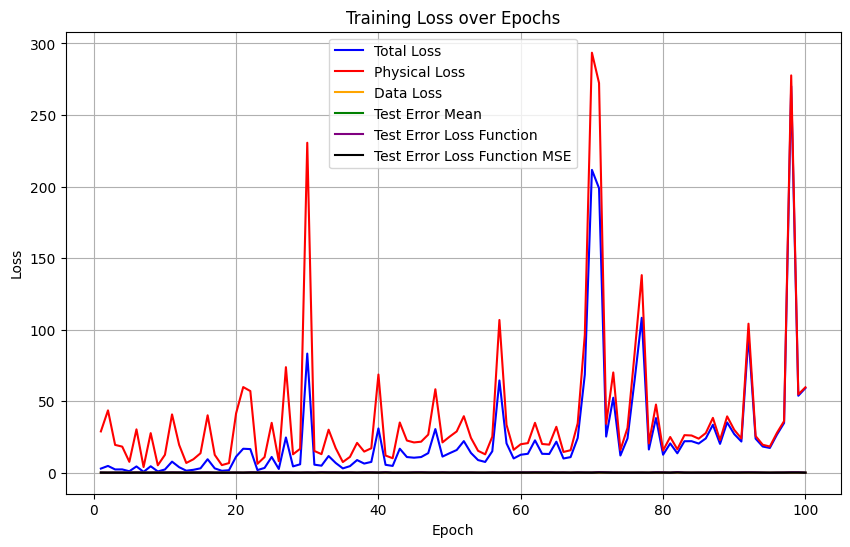

Period 1 was completed and the model states have been saved at this moment
training finished


In [43]:
if use_saved_model == False:
    
    if training_type not in ["Heat Equation", "Heat Conservation", "Data_driven"]:
                    raise ValueError("Incorrect training_type. Needs to be 'Heat Conservation', 'Heat Equation' or 'Data_driven'.")
    
    if data_handling not in ["random", "structured"]:
        raise ValueError("Incorrect Data handling. Needs to be 'random'  or 'structured'.")
    
    loss_function = nn.MSELoss()
    loss_function2 = nn.L1Loss()
    
    #Choosing the Optimizer
    optimizer_freeze = torch.optim.Adam(model_freeze.parameters(), lr=0.0005)
    
    # necessary for the documentation of the Trainingevolution
    total_loss_list = []
    physical_loss_list = []
    red_physical_loss_list = []
    data_loss_list = []
    test_error_mean_list = []
    test_error_MAE_list = []
    test_error_MSE_list = []
    trainingsequences = []
    counter = 0

    for j in range(0, len(train_datasets)):      
        if freeze == True:
            num_layers_to_freeze = j
            model_freeze.freeze_layers(model_freeze, j)
            if num_layers_to_freeze == 0:
                print(f'First training cycle is conducted without freezed layers: {num_layers_to_freeze}')
            else:
                print(f'Amount of freezed layers: {num_layers_to_freeze}')

        print(f"Cycle {j+1} of {len(train_datasets)} cycles has started")
        
        if data_handling == "structured":
            train_inout_seq = train_datasets[j]
        
        for i in range(epochs):
            counter += 1
            for _ in range(subcycle):
                
                if data_handling == "random":
                    #random call off the trainingdataset
                    random_call = np.random.randint(len(train_datasets))
                    train_inout_seq = train_datasets[random_call]
                
                #random call of the training batch
                num = np.random.randint(len(train_inout_seq))
                #getting training batch
                X_train = train_inout_seq[num][0].to(device)
                #gettin labeld batch
                y_target = train_inout_seq[num][1].to(device)
                
                optimizer_freeze.zero_grad()

                model_freeze.c_h = (torch.zeros(len(train_datasets), 1, hidden_layer_size).to(device),
                                torch.zeros(len(train_datasets), 1, hidden_layer_size).to(device))

                y_pred = model_freeze(X_train)

                single_loss = loss_function(y_pred.view(1,nx), y_target)

                #preparing the data for the physical loss
                #getting the previous timestep
                X_train_3D = torch.tensor(X_train, dtype=torch.float32).unsqueeze(0)

                prev_val = X_train_3D[0, -1, :]
        
                prev_val = prev_val.detach().numpy()
                prev_val = scaler.inverse_transform(prev_val.reshape(1, -1))
                prev_val = prev_val.flatten()
                

                #rescaling the actual prediction
                y_pred_real = y_pred.detach().numpy()
                y_pred_real = scaler.inverse_transform(y_pred_real.reshape(1, -1))
                y_pred_real = y_pred_real.flatten()

                #for comparison the data target
                y_target_real = y_target.detach().cpu().numpy()
                y_target_real = scaler.inverse_transform(y_target_real.reshape(1, -1))

                if training_type == "Data_driven":
                    total_loss = single_loss
                elif training_type == "Heat Conservation":
                    Heat_conserv_loss = diffusion_functions_meta_training.Heat_conservation(y_pred_real, prev_val, dx)
                    Heat_conserv_loss = abs(Heat_conserv_loss)
                    alpha = 0.1 + 0.9 * (i / epochs)
                    total_loss = single_loss + alpha * Heat_conserv_loss
                elif training_type == "Heat Equation":
                    Heat_equation_loss = diffusion_functions_meta_training.Heat_eq_loss_1D(y_pred_real, prev_val, dx, dt, alpha)
                    Heat_equation_loss = np.mean(np.abs(Heat_equation_loss))
                    alpha = 0.1 + 0.9 * (i / epochs)
                    total_loss = single_loss + alpha * Heat_equation_loss
                else:
                    raise ValueError("Incorrect training_type. Needs to be 'Heat Conservation', 'Heat Equation' or 'Data_driven'.")
                    
                total_loss.backward()
                optimizer_freeze.step()

                test_dataset_tensor = torch.tensor(test_datasets[j])
                prediction, test_data, test_error_mean = diffusion_functions_meta_training.training_tester(model_freeze, test_dataset_tensor, num_layers, device, nx, hidden_layer_size)

                test_loss_MSE = loss_function(torch.tensor(test_data), torch.tensor(prediction))
                test_loss_MAE = loss_function2(torch.tensor(test_data), torch.tensor(prediction))

            if training_type == "Data_driven":
                not_considered = 0
                physical_loss_list.append(not_considered)
            elif training_type == "Heat Conservation":
                physical_loss_list.append(Heat_conserv_loss.item())
            elif training_type == "Heat Equation":
                physical_loss_list.append(Heat_equation_loss.item())    
            else:
                raise ValueError("Incorrect training_type. Needs to be 'Heat Conservation', 'Heat Equation' or 'Data_driven'.")
                       
            total_loss_list.append(total_loss.item())
            data_loss_list.append(single_loss.item())
            test_error_mean_list.append(test_error_mean.item())
            test_error_MAE_list.append(test_loss_MAE.item())
            test_error_MSE_list.append(test_loss_MSE.item())

            trainingsequences.append(counter)

            if i%25 == 1:

                print(f'epoch: {i:3} data loss: {single_loss.item():10.8f}')
                print(f'epoch: {i:3} total loss: {total_loss.item():10.8f}')
                if training_type == "Heat Conservation":
                    print(f'epoch: {i:3} Heat Conservation loss: {Heat_conserv_loss.item():10.8f}')
                if training_type == "Heat Equation":
                    print(f'epoch: {i:3} Heat Equation loss: {Heat_equation_loss.item():10.8f}')
                print(f'the test error is {test_error_mean.item()}')
                # print(f'the test error ist {test_loss.item()}')

        df_losses = pd.DataFrame({
            "Epoch": trainingsequences,
            "Total Loss": total_loss_list,
            "Physical Loss": physical_loss_list,
            "Data Loss": data_loss_list,
            "Test Error Mean": test_error_mean_list,
            "Test Error Loss Function": test_error_MAE_list,
            "Test Error Loss Function MSE": test_error_MSE_list
        })

        # Path to download folder
        downloads_path = os.path.join(os.path.expanduser('~'), 'Downloads')
        
        # Save csv
        df_losses.to_csv(os.path.join(downloads_path, f"trainingloss_cycle{j+1}_{filename}.csv"), index=False)
        
        print(f"CSV-Datei gespeichert als 'trainingloss_cycle{j+1}_{filename}.csv'")

        # Create plot
        plt.figure(figsize=(10, 6))

        plt.plot(df_losses["Epoch"], df_losses["Total Loss"], label="Total Loss", color="blue")      
        plt.plot(df_losses["Epoch"], df_losses["Physical Loss"], label="Physical Loss", color="red")
        plt.plot(df_losses["Epoch"], df_losses["Data Loss"], label="Data Loss", color="orange")
        plt.plot(df_losses["Epoch"], df_losses["Test Error Mean"], label="Test Error Mean", color="green")  
        plt.plot(df_losses["Epoch"], df_losses["Test Error Loss Function"], label="Test Error Loss Function", color="purple") 
        plt.plot(df_losses["Epoch"], df_losses["Test Error Loss Function MSE"], label="Test Error Loss Function MSE", color="black")  

        #titles
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training Loss over Epochs")
        plt.legend()
        plt.grid(True)

        plt.show()

        print(f"Period {j+1} was completed and the model states have been saved at this moment")
        torch.save(model_freeze.state_dict(), filename)
    print("training finished")
    
    torch.save(model_freeze.state_dict(), filename)
    

In [45]:
test_actual_predictions, test_absolute_pred_error, test_single_mean_error = diffusion_functions_meta_training.OneStep(model_freeze, test_datasets[0], num_layers, nx, train_window=10, steps=100)
filepath = r"D:\\"
diffusion_functions_meta_training.save_to_csv(test_datasets[0], test_actual_predictions, test_absolute_pred_error, filepath, filename)

data set length = 751


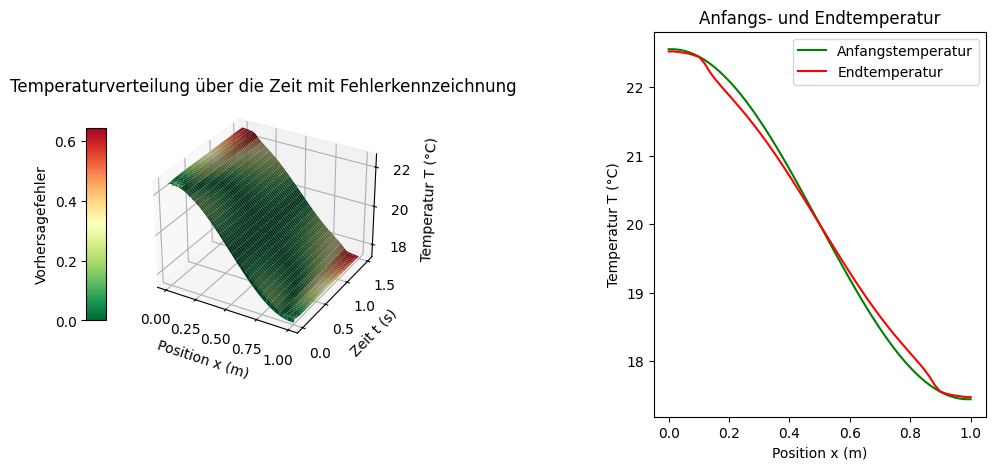

data set length = 751


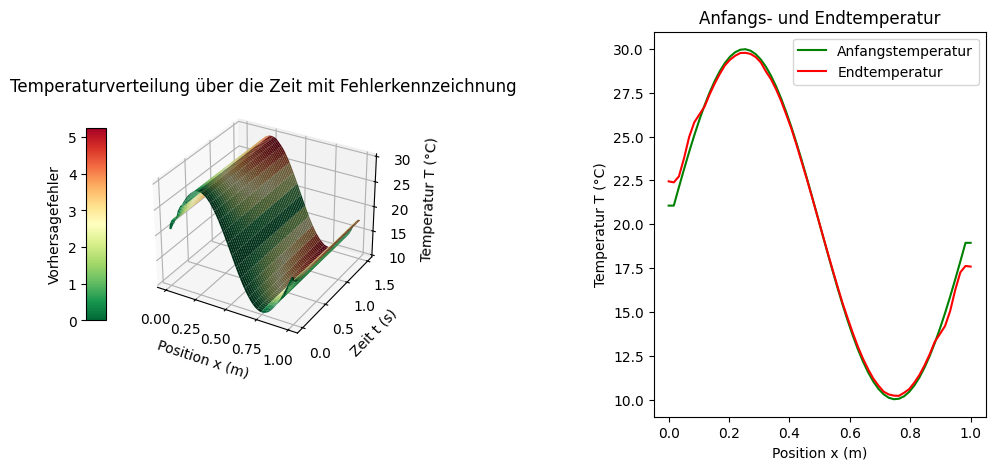

In [ ]:
diffusion_functions_meta_training.heat_distribution_and_error_plotter(test_actual_predictions, test_absolute_pred_error, length, nx, time)

# plotting the train_data
# training_actual_predictions, training_absolute_pred_error, training_single_mean_error = diffusion_functions_meta_training.OneStep(model_freeze, simulation_sets[0][:len(test_datasets[0])], num_layers, nx, train_window=10, steps=100)
# diffusion_functions_meta_training.heat_distribution_and_error_plotter(training_actual_predictions, training_absolute_pred_error, length, nx, time)

In [48]:
diffusion_functions_meta_training.plot_temp_distribution(actual_predictions, length, nx, time)

AttributeError: 'ModuleSpec' object has no attribute 'plot_temp_distribution'